# Importação de bibliotecas

In [1]:
from copy import deepcopy
import os
import pickle
import sys
from tqdm import tqdm
import numpy as np
import scipy.io as io
import scipy as scp
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle, resample
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression

from pump_utils import process, plots, models


# Manipulação dos dados

## Abrindo o diretório


In [119]:
path='F:\FACUL\FACULDADE\PG1\Dados'
os.listdir(path)
Df_v1 = pd.read_csv(f'{path}\\sensor.csv')

## Obtendo o Dataframe

In [120]:
Df_v2 = Df_v1.drop(columns='Unnamed: 0') #Coluna repete index
# Cols=Df_v2.columns

In [121]:
Df_v2['timestamp'] = Df_v2['timestamp'].astype('datetime64')

In [122]:
Df_v2['machine_status'].loc[Df_v2['machine_status'] == 'RECOVERING']

17156     RECOVERING
17157     RECOVERING
17158     RECOVERING
17159     RECOVERING
17160     RECOVERING
             ...    
166511    RECOVERING
166512    RECOVERING
166513    RECOVERING
166514    RECOVERING
166515    RECOVERING
Name: machine_status, Length: 14477, dtype: object

In [123]:
Df_v2['timestamp'].iloc[166440            ]

Timestamp('2018-07-25 14:00:00')

# Tratamento dos dados

In [124]:
Df_v2 = Df_v2.drop(columns = 'sensor_15')

In [125]:
Df_v2['b_machine_status'] = Df_v2['machine_status'].apply(lambda x: x if x == 'NORMAL' else 'ANOMALY')

In [126]:
# Df_v2

In [127]:
corr = Df_v2.corr()
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True
corr[mask] = np.nan
(corr
 .style
 .background_gradient(cmap='coolwarm', axis=None, vmin=-1, vmax=1)
 .highlight_null(null_color='#f1f1f1')  # Color NaNs grey
 .set_precision(2))

C:\Users\jorda\AppData\Local\Temp/ipykernel_11696/1279425328.py:5: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  (corr


,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,sensor_10,sensor_11,sensor_12,sensor_13,sensor_14,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,sensor_22,sensor_23,sensor_24,sensor_25,sensor_26,sensor_27,sensor_28,sensor_29,sensor_30,sensor_31,sensor_32,sensor_33,sensor_34,sensor_35,sensor_36,sensor_37,sensor_38,sensor_39,sensor_40,sensor_41,sensor_42,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51
sensor_00,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
sensor_01,0.34,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
sensor_02,0.64,0.74,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
sensor_03,0.39,0.69,0.82,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
sensor_04,0.94,0.68,0.82,0.68,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
sensor_05,0.76,0.16,0.26,0.15,0.39,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
sensor_06,0.75,0.51,0.66,0.56,0.80,0.59,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
sensor_07,0.62,0.48,0.61,0.49,0.69,0.54,0.85,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
sensor_08,0.59,0.46,0.55,0.45,0.63,0.46,0.76,0.91,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
sensor_09,0.52,0.47,0.60,0.48,0.61,0.50,0.78,0.90,0.84,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


In [128]:
Df_v2 = Df_v2.drop(columns = ['sensor_00','sensor_08','sensor_09','sensor_14','sensor_16','sensor_17','sensor_18','sensor_19','sensor_20','sensor_21','sensor_22','sensor_23','sensor_24','sensor_25','sensor_26'])

In [129]:
# plots.redundant_features(Df_v2)

In [130]:
corr = Df_v2.corr()
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True
corr[mask] = np.nan
(corr
 .style
 .background_gradient(cmap='coolwarm', axis=None, vmin=-1, vmax=1)
 .highlight_null(null_color='#f1f1f1')  # Color NaNs grey
 .set_precision(2))

C:\Users\jorda\AppData\Local\Temp/ipykernel_11696/1279425328.py:5: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  (corr


,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_10,sensor_11,sensor_12,sensor_13,sensor_27,sensor_28,sensor_29,sensor_30,sensor_31,sensor_32,sensor_33,sensor_34,sensor_35,sensor_36,sensor_37,sensor_38,sensor_39,sensor_40,sensor_41,sensor_42,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51
sensor_01,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
sensor_02,0.74,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
sensor_03,0.69,0.82,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
sensor_04,0.68,0.82,0.68,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
sensor_05,0.16,0.26,0.15,0.39,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
sensor_06,0.51,0.66,0.56,0.80,0.59,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
sensor_07,0.48,0.61,0.49,0.69,0.54,0.85,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
sensor_10,0.60,0.76,0.62,0.91,0.44,0.76,0.64,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
sensor_11,0.56,0.71,0.67,0.86,0.40,0.75,0.63,0.83,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
sensor_12,0.51,0.69,0.61,0.80,0.38,0.67,0.55,0.77,0.83,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


In [131]:
null_list = Df_v2.isnull().sum()
(null_list[null_list != 0] / Df_v2.shape[0])*100

sensor_01     0.167484
sensor_02     0.008624
sensor_03     0.008624
sensor_04     0.008624
sensor_05     0.008624
sensor_06     2.177741
sensor_07     2.474129
sensor_10     0.008624
sensor_11     0.008624
sensor_12     0.008624
sensor_13     0.008624
sensor_27     0.007262
sensor_28     0.007262
sensor_29     0.032680
sensor_30     0.118464
sensor_31     0.007262
sensor_32     0.030864
sensor_33     0.007262
sensor_34     0.007262
sensor_35     0.007262
sensor_36     0.007262
sensor_37     0.007262
sensor_38     0.012255
sensor_39     0.012255
sensor_40     0.012255
sensor_41     0.012255
sensor_42     0.012255
sensor_43     0.012255
sensor_44     0.012255
sensor_45     0.012255
sensor_46     0.012255
sensor_47     0.012255
sensor_48     0.012255
sensor_49     0.012255
sensor_50    34.956881
sensor_51     6.982117
dtype: float64

In [132]:
Df_v2 = Df_v2.drop(columns = ['sensor_50'])

status options: 
['NORMAL' 'BROKEN' 'RECOVERING']

NORMAL        205836
RECOVERING     14477
BROKEN             7
Name: machine_status, dtype: int64



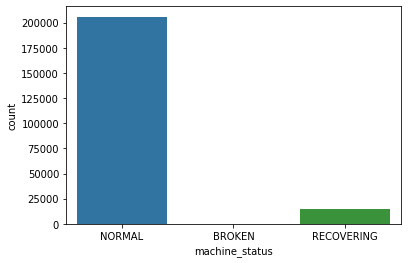

In [133]:
sns.countplot(data=Df_v2, x='machine_status')
print( 'status options: ');  
print( Df_v2['machine_status'].unique()); 
print() 
print (Df_v2['machine_status'].value_counts()); print()

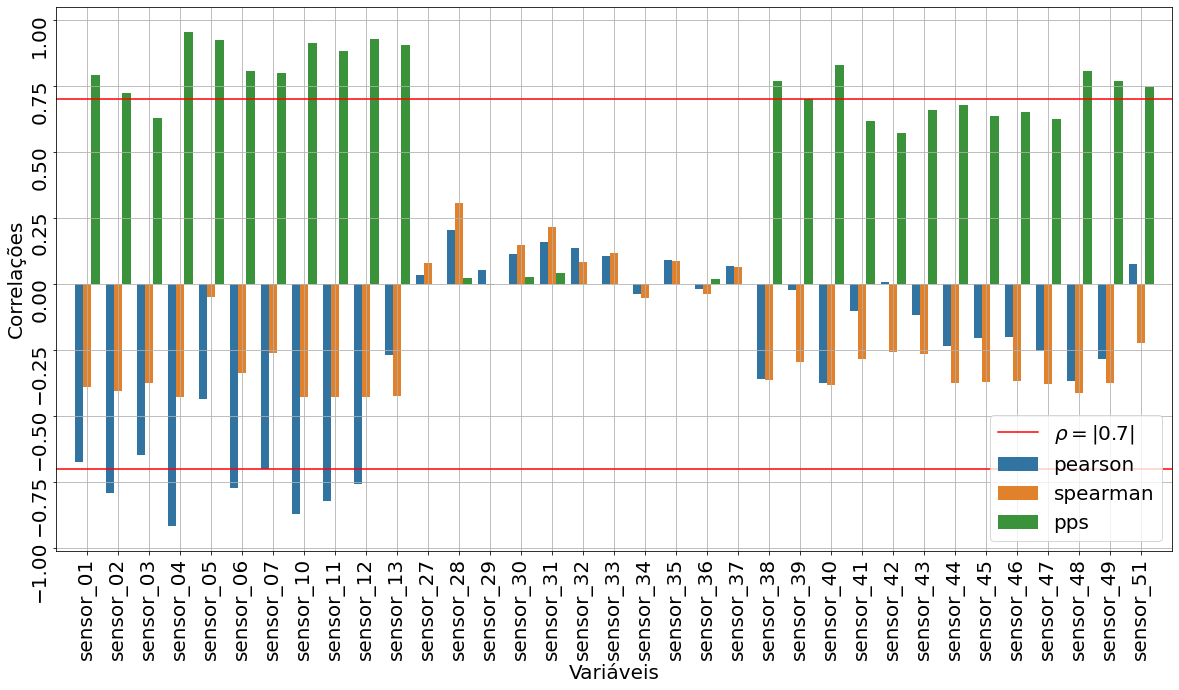

In [134]:
plots.corr_plot(Df_v2, th=.7)

In [135]:
Df_v2 = Df_v2.drop(columns = ['sensor_03','sensor_27','sensor_28','sensor_29','sensor_30','sensor_31','sensor_32','sensor_33','sensor_34','sensor_35','sensor_36','sensor_37',
'sensor_41','sensor_42','sensor_43','sensor_44','sensor_45','sensor_46','sensor_47'])

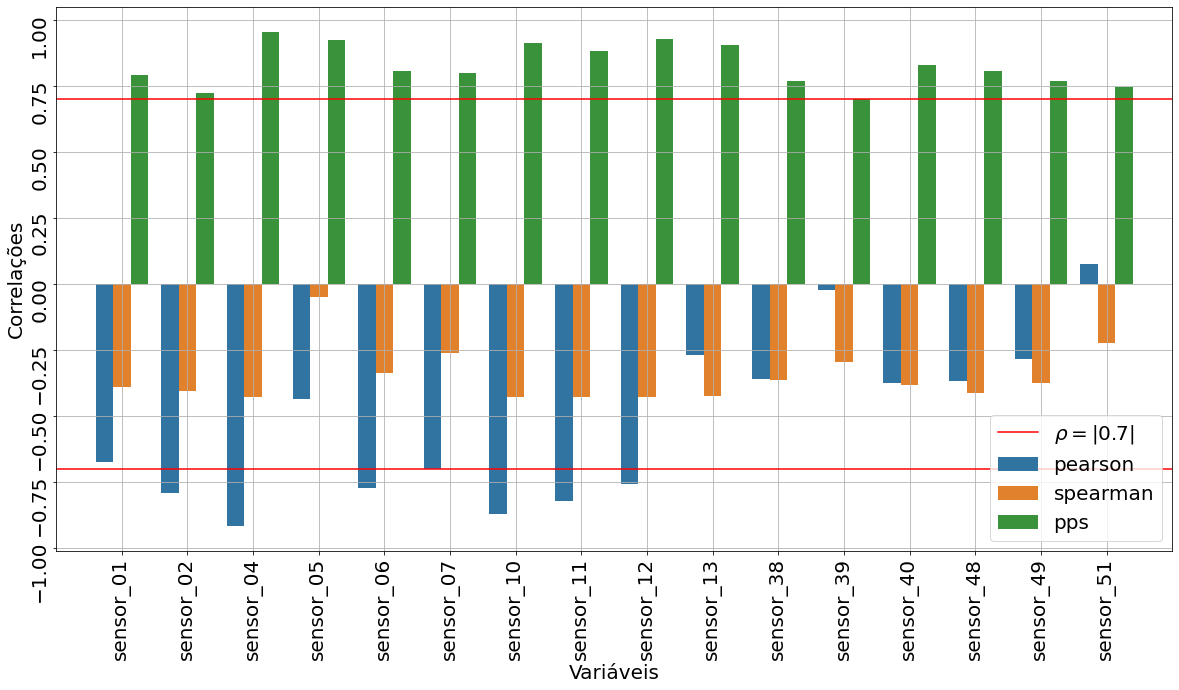

In [136]:
plots.corr_plot(Df_v2, th=.7)

In [137]:
# plots.redundant_features(Df_v2)

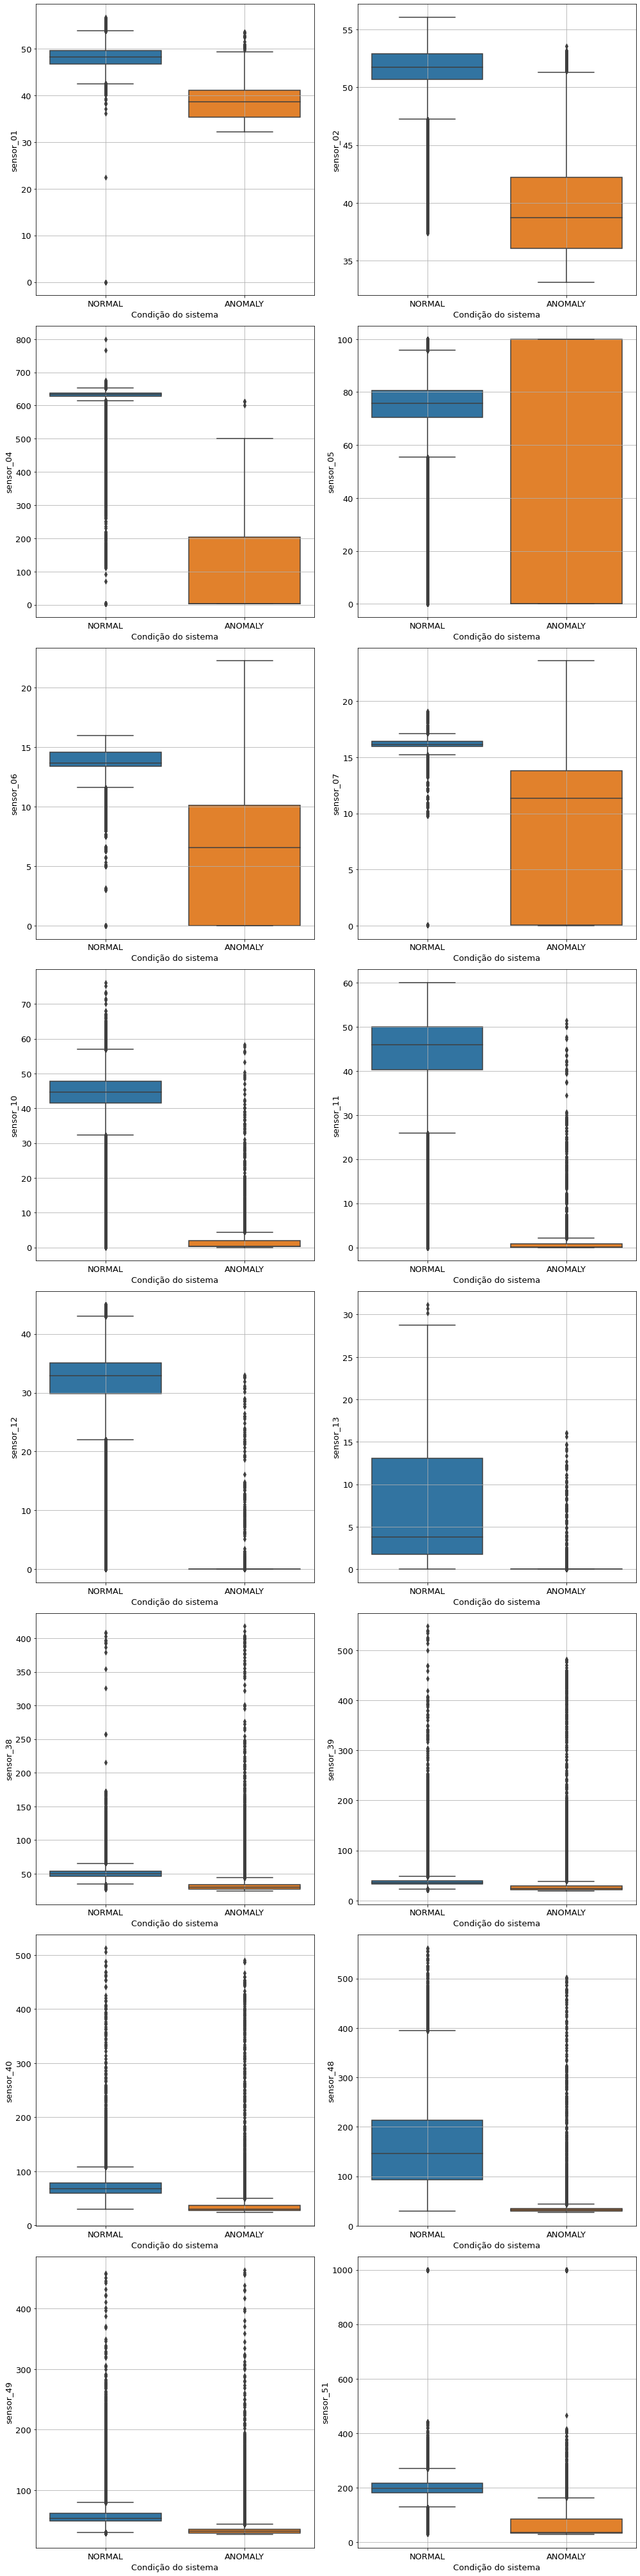

In [138]:
from pump_utils.plots import boxplot


boxplot(data= Df_v2)

# Transformando em .Parquet

In [139]:
Df_v2.to_parquet('F:\FACUL\FACULDADE\PG1\Dados\Dados_Pump.parquet', index=False)

# Features

In [2]:
path='F:\FACUL\FACULDADE\PG1\Dados'
Df_v2 = pd.read_parquet(path+r'\Dados_Pump.parquet')

status options: 
['NORMAL' 'BROKEN' 'RECOVERING']

NORMAL        205836
RECOVERING     14477
BROKEN             7
Name: machine_status, dtype: int64

{'BROKEN': 0, 'NORMAL': 1, 'RECOVERING': 2}


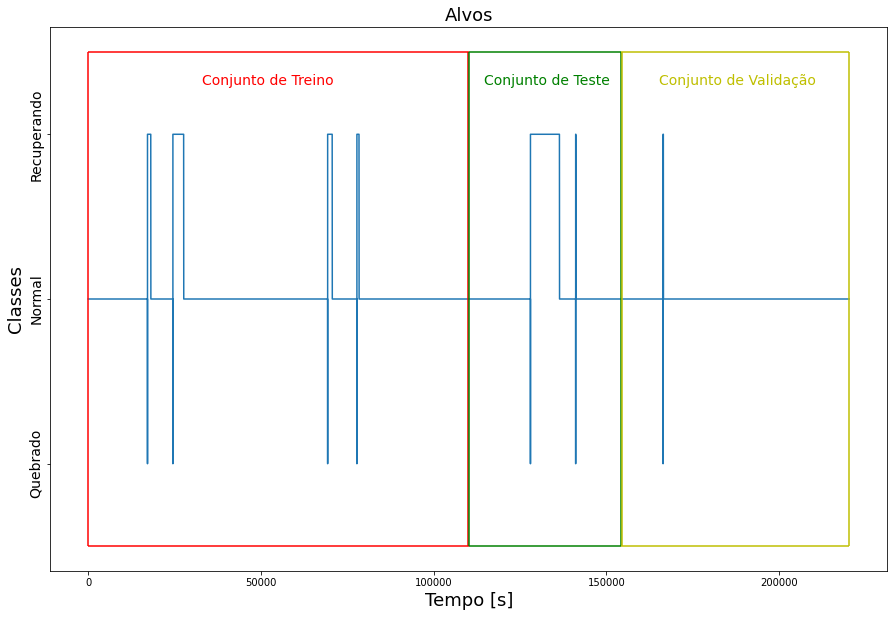

In [10]:
from sklearn import preprocessing
from matplotlib.patches import Rectangle
#  Get some info on the target-data

print( 'status options: ');  
print( Df_v2['machine_status'].unique()); 
print() # Get the unique values for class
print (Df_v2['machine_status'].value_counts()); print() # Count the Classes to see how many we got from each

# Convert the classes from string to values by using the sckit-learn mapper

le = preprocessing.LabelEncoder() #get the label Encoder
le.fit(Df_v2['machine_status']) #fit it to the data that the encoder knows what to do
encoded_y=pd.DataFrame(le.transform(Df_v2['machine_status']),columns=['target']) #finally transform the data and put it into a pandas data frame for easier use

#Get the Label map
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_))) # To be able to later indentify what is what, create a label map
print(le_name_mapping)

x=np.linspace (1,len(encoded_y),len(encoded_y)) # create x-axis (could also be the converted timestamp column)

fig, ax = plt.subplots(1,figsize=(15,10))
plt.plot(x,encoded_y) 
plt.ylabel('Classes', fontsize= 18)
plt.xlabel('Tempo [s]', fontsize= 18)
plt.title('Alvos', fontsize= 18)
labels = ['Normal','Quebrado','Recuperando'] # Give the y-axis the Class lables we found earlier
plt.yticks([1,0,2], labels, rotation='vertical',verticalalignment='center' ,fontsize= 14) # Set the y-ticks to three to only show the classnames

for i in range(1): #Inserção de linhas para conjunto de treino
    plt.vlines(int(len(Df_v2['sensor_01'])*0.4990), -0.5, 2.5, colors='r', linestyles='solid', label='', data=None)
    plt.vlines(-0.5, -0.5, 2.5, colors='r', linestyles='solid', label='', data=None)
    plt.hlines(2.5,int(len(Df_v2['sensor_01'])*0.5), 2.5, colors='r', linestyles='solid', label='Training Set', data=None)
    plt.hlines(-0.5,int(len(Df_v2['sensor_01'])*0.5), 2.5, colors='r', linestyles='solid', label='', data=None)
    plt.text(int(len(Df_v2['sensor_01'])*0.15), 2.3, 'Conjunto de Treino', fontsize=14, color = 'r')

for i in range(1): #Inserção de linhas para conjunto de teste
    plt.vlines(int(len(Df_v2['sensor_01'])*0.7), -0.5, 2.5, colors='g', linestyles='solid', label='', data=None)
    plt.vlines(int(len(Df_v2['sensor_01'])*0.5), -0.5, 2.5, colors='g', linestyles='solid', label='', data=None)
    plt.hlines(2.5,int(len(Df_v2['sensor_01'])*0.5), int(len(Df_v2['sensor_01'])*0.7),  colors='g', linestyles='solid', label='Test Set', data=None)
    plt.hlines(-0.5,int(len(Df_v2['sensor_01'])*0.5), int(len(Df_v2['sensor_01'])*0.7), colors='g', linestyles='solid', label='', data=None)
    plt.text(int(len(Df_v2['sensor_01'])*0.52), 2.3, 'Conjunto de Teste', fontsize=14, color = 'g')

for i in range(1): #Inserção de linhas para conjunto de validação
    plt.vlines(int(len(Df_v2['sensor_01'])*1), -0.5, 2.5, colors='y', linestyles='solid', label='', data=None)
    plt.vlines(int(len(Df_v2['sensor_01'])*0.7010), -0.5, 2.5, colors='y', linestyles='solid', label='', data=None)
    plt.hlines(2.5,int(len(Df_v2['sensor_01'])*0.7), int(len(Df_v2['sensor_01'])*1),  colors='y', linestyles='solid', label='Test Set', data=None)
    plt.hlines(-0.5,int(len(Df_v2['sensor_01'])*0.7), int(len(Df_v2['sensor_01'])*1), colors='y', linestyles='solid', label='', data=None)
    plt.text(int(len(Df_v2['sensor_01'])*0.75), 2.3, 'Conjunto de Validação', fontsize=14, color = 'y')

plt.show()  

In [146]:
Df_v2["sensor_51"].isnull().loc[Df_v2["sensor_51"].isnull()==True]
# (null_list[null_list != 0] / Df_v2.shape[0])*100

# null_list = Df_v2.isnull().sum()
# (null_list[null_list != 0] / Df_v2.shape[0])*100


25112     True
38508     True
38509     True
38510     True
38511     True
          ... 
145993    True
145994    True
220008    True
220009    True
220010    True
Name: sensor_51, Length: 15383, dtype: bool

In [3]:
# fig, ax = plt.subplots(1,figsize=(20,10))
# plt.plot(Df_v2['sensor_51'])

In [11]:
Df_v2.interpolate(method = 'bfill', inplace = True)

In [4]:
# fig, ax = plt.subplots(1,figsize=(20,10))
# plt.plot(Df_v2['sensor_51'])

In [12]:
# Df_v2.head()
Df_v2_norm = pd.DataFrame()

for sensors in tqdm(Df_v2.columns):
    if  sensors == 'timestamp':
        pass
    else:
        if  sensors == 'machine_status':
            pass
        else:
            if  sensors == 'b_machine_status':
                pass
            else:
                x_max = Df_v2[sensors].max()
                x_min = Df_v2[sensors].min()
                x_targ_min = 0
                x_targ_max = 1         
                interp = scp.interpolate.interp1d([x_min,x_max],[x_targ_min,x_targ_max], kind= 'linear')
                Df_v2_norm[sensors] = interp (Df_v2[sensors])

Df_v2_norm['machine_status'] = Df_v2['machine_status'].copy()    
Df_v2_norm['timestamp'] = Df_v2['timestamp'].copy()    
Df_v2_norm['b_machine_status'] = Df_v2['b_machine_status'].copy() 



100%|██████████| 19/19 [00:00<00:00, 155.79it/s]


In [13]:
null_list = Df_v2_norm.isnull().sum()
(null_list[null_list != 0] / Df_v2_norm.shape[0])*100

Series([], dtype: float64)

In [14]:
# Df_v2_norm.interpolate(method = 'backfill',axis = 0, inplace = True)
# Df_v2.interpolate(method = 'backfill',axis = 0, inplace = True)

In [12]:
# fig, ax = plt.subplots(1,figsize=(30,15))
# plt.plot(Df_v2['timestamp'], Df_v2['sensor_04'])

In [14]:
Df_v2_down_1={}
Df_v2_down_2={}
Df_v2_down_3={}
Fator_train = 0.5
Fator_test = 0.7
Fator_valid = 1

Cols=Df_v2.columns
for sensors in Cols:    # Montagem de conjunto de dados com dataset original

    tam = len(Df_v2[sensors])
    if not Df_v2_down_1.get(f'{sensors}'):
        Df_v2_down_1[f'{sensors}'] = {}
    Df_v2_down_1[f'{sensors}'] = Df_v2[sensors][range(0,int(len(Df_v2[sensors])*Fator_train),1)]

    tam = len(Df_v2[sensors])    
    if not Df_v2_down_2.get(f'{sensors}'):
        Df_v2_down_2[f'{sensors}'] = {}   
    Df_v2_down_2[f'{sensors}'] = Df_v2[sensors][range(int(len(Df_v2[sensors])*Fator_train),int(len(Df_v2[sensors])*Fator_test),1)]

    tam = len(Df_v2[sensors])    
    if not Df_v2_down_3.get(f'{sensors}'):
        Df_v2_down_3[f'{sensors}'] = {}   
    Df_v2_down_3[f'{sensors}'] = Df_v2[sensors][range(int(len(Df_v2[sensors])*Fator_test),int(len(Df_v2[sensors])*Fator_valid),1)]
Df_train = pd.DataFrame.from_dict(Df_v2_down_1)
Df_test = pd.DataFrame.from_dict(Df_v2_down_2)
Df_valid = pd.DataFrame.from_dict(Df_v2_down_3)

Df_v2_down_1={}
Df_v2_down_2={}
Df_v2_down_3={}
for sensors in Cols:    # Montagem de conjunto de dados com dataset normalizado de 0 até 1    

    tam = len(Df_v2[sensors])
    if not Df_v2_down_1.get(f'{sensors}'):
        Df_v2_down_1[f'{sensors}'] = {}
    Df_v2_down_1[f'{sensors}'] = Df_v2_norm[sensors][range(0,int(len(Df_v2[sensors])*Fator_train),1)]

    tam = len(Df_v2[sensors])    
    if not Df_v2_down_2.get(f'{sensors}'):
        Df_v2_down_2[f'{sensors}'] = {}   
    Df_v2_down_2[f'{sensors}'] = Df_v2_norm[sensors][range(int(len(Df_v2[sensors])*Fator_train),int(len(Df_v2[sensors])*Fator_test),1)]

    tam = len(Df_v2[sensors])    
    if not Df_v2_down_3.get(f'{sensors}'):
        Df_v2_down_3[f'{sensors}'] = {}   
    Df_v2_down_3[f'{sensors}'] = Df_v2_norm[sensors][range(int(len(Df_v2[sensors])*Fator_test),int(len(Df_v2[sensors])*Fator_valid),1)]

Df_train_norm = pd.DataFrame.from_dict(Df_v2_down_1)
# Df_train_norm.reset_index(inplace=True, drop=True)
Df_test_norm = pd.DataFrame.from_dict(Df_v2_down_2)
# Df_test_norm.reset_index(inplace=True, drop=True)
Df_valid_norm = pd.DataFrame.from_dict(Df_v2_down_3)
# Df_valid_norm.reset_index(inplace=True, drop=True)


In [7]:
# print( 'Train Set: ');  
# # print( Df_train['machine_status'].unique()); 
# # print() # Get the unique values for class
# print (Df_train['machine_status'].value_counts()); 
# print() # Count the Classes to see how many we got from each

# print( 'Test Set: ');  
# # print( Df_test['machine_status'].unique()); 
# # print() # Get the unique values for class
# print (Df_test['machine_status'].value_counts()); 
# print() # Count the Classes to see how many we got from each

# print( 'Validation Set: ');  
# # print( Df_valid['machine_status'].unique()); 
# # print() # Get the unique values for class
# print (Df_valid['machine_status'].value_counts()); 
# print() # Count the Classes to see how many we got from each

print( 'Train Set Normalized: ');  
# print( Df_train_norm['machine_status'].unique()); 
# print() # Get the unique values for class
print (Df_train_norm['machine_status'].value_counts()); 
print() # Count the Classes to see how many we got from each

print( 'Test Set Normalized: ');  
# print( Df_test_norm['machine_status'].unique()); 
# print() # Get the unique values for class
print (Df_test_norm['machine_status'].value_counts()); 
print() # Count the Classes to see how many we got from each

print( 'Validation Set Normalized: ');  
# print( Df_valid_norm['machine_status'].unique()); 
# print() # Get the unique values for class
print (Df_valid_norm['machine_status'].value_counts()); 
print() # Count the Classes to see how many we got from each

Train Set Normalized: 
NORMAL        104185
RECOVERING      5971
BROKEN             4
Name: machine_status, dtype: int64

Test Set Normalized: 
NORMAL        35631
RECOVERING     8431
BROKEN            2
Name: machine_status, dtype: int64

Validation Set Normalized: 
NORMAL        66020
RECOVERING       75
BROKEN            1
Name: machine_status, dtype: int64



In [16]:
# fig, ax = plt.subplots(2,figsize=(30,15))
# ax[0].plot(Df_v2_norm['timestamp'], Df_v2_norm['sensor_04'])
# ax[0].axhline(y = Df_v2_norm['sensor_04'].median(), color = 'r', linestyle = '-')
# ax[1].plot(Df_train['timestamp'], Df_train['sensor_04'])
# ax[1].axhline(y = Df_train['sensor_04'].median(), color = 'r', linestyle = '--')

In [15]:
Df_train['b_machine_status'] = Df_v2['machine_status'].apply(lambda x: 1 if x =='BROKEN' or x == 'RECOVERING' else 0)
Df_test['b_machine_status'] = Df_v2['machine_status'].apply(lambda x: 1 if x =='BROKEN' or x == 'RECOVERING' else 0)
Df_valid['b_machine_status'] = Df_v2['machine_status'].apply(lambda x: 1 if x =='BROKEN' or x == 'RECOVERING' else 0)

Df_train_norm['b_machine_status'] = Df_v2['machine_status'].apply(lambda x: 1 if x =='BROKEN' or x == 'RECOVERING' else 0)
Df_test_norm['b_machine_status'] = Df_v2['machine_status'].apply(lambda x: 1 if x =='BROKEN' or x == 'RECOVERING' else 0)
Df_valid_norm['b_machine_status'] = Df_v2['machine_status'].apply(lambda x: 1 if x =='BROKEN' or x == 'RECOVERING' else 0)

In [17]:
# separação em conjunto de treino, teste e validação

xtrain = Df_train.drop(columns=['b_machine_status','machine_status','timestamp'])
ytrain = Df_train['b_machine_status']
xtest = Df_test.drop(columns=['b_machine_status','machine_status','timestamp'])
ytest = Df_test['b_machine_status']
xvalid = Df_valid.drop(columns=['b_machine_status','machine_status','timestamp'])
yvalid = Df_valid['b_machine_status']

xtrain_norm = Df_train_norm.drop(columns=['b_machine_status','machine_status','timestamp'])
ytrain_norm = Df_train_norm['b_machine_status']
xtest_norm = Df_test_norm.drop(columns=['b_machine_status','machine_status','timestamp'])
ytest_norm = Df_test_norm['b_machine_status']
xvalid_norm = Df_valid_norm.drop(columns=['b_machine_status','machine_status','timestamp'])
yvalid_norm = Df_valid_norm['b_machine_status']

In [64]:
# yvalid.value_counts()

In [11]:
# balanceamento dos dados de treino
# train_set = pd.concat([xtrain, ytrain], axis='columns')
# an_df = train_set.groupby('b_machine_status').get_group(1)
# n_df = train_set.groupby('b_machine_status').get_group(0).sample(n=an_df.shape[0], random_state=42)
# train_set = shuffle(pd.concat([n_df, an_df]))

# xtrain = train_set.drop(columns='b_machine_status')
# ytrain = train_set['b_machine_status']

# train_set_norm = pd.concat([xtrain_norm, ytrain_norm], axis='columns')
# an_df_norm = train_set_norm.groupby('b_machine_status').get_group(1)
# n_df_norm = train_set_norm.groupby('b_machine_status').get_group(0).sample(n=an_df_norm.shape[0], random_state=42)
# train_set_norm = shuffle(pd.concat([n_df_norm, an_df_norm]))

# xtrain_norm = train_set_norm.drop(columns='b_machine_status')
# ytrain_norm = train_set_norm['b_machine_status']

In [21]:
# balanceamento dos dados de teste
# test_set = pd.concat([xtest, ytest], axis='columns')
# an_df = test_set.groupby('b_machine_status').get_group(1)
# n_df = test_set.groupby('b_machine_status').get_group(0).sample(n=an_df.shape[0], random_state=42)
# test_set = shuffle(pd.concat([n_df, an_df]))

# xtest = test_set.drop(columns='b_machine_status')
# ytest = test_set['b_machine_status']

# test_set_norm = pd.concat([xtest_norm, ytest_norm], axis='columns')
# an_df_norm = test_set_norm.groupby('b_machine_status').get_group(1)
# n_df_norm = test_set_norm.groupby('b_machine_status').get_group(0).sample(n=an_df_norm.shape[0], random_state=42)
# test_set_norm = shuffle(pd.concat([n_df_norm, an_df_norm]))

# xtest_norm = test_set_norm.drop(columns='b_machine_status')
# ytest_norm = test_set_norm['b_machine_status']

In [22]:
# balanceamento dos dados de validação
# valid_set = pd.concat([xvalid, yvalid], axis='columns')
# an_df = valid_set.groupby('b_machine_status').get_group(1)
# n_df = valid_set.groupby('b_machine_status').get_group(0).sample(n=an_df.shape[0], random_state=42)
# valid_set = shuffle(pd.concat([n_df, an_df]))

# xvalid = valid_set.drop(columns='b_machine_status')
# yvalid = valid_set['b_machine_status']

# Criação e processamento do modelo

Random Forest usando Dataset original

In [12]:
# criação e treinamento do modelo
rf = models.RandForestClass(n_estimators = 500, criterion = 'entropy')
rf.fit(xtrain, ytrain)
# rf.fit(xtrain_norm, ytrain_norm)

RandForestClass(criterion='entropy', n_estimators=500)

Precisão do modelo: 0.168550290486565


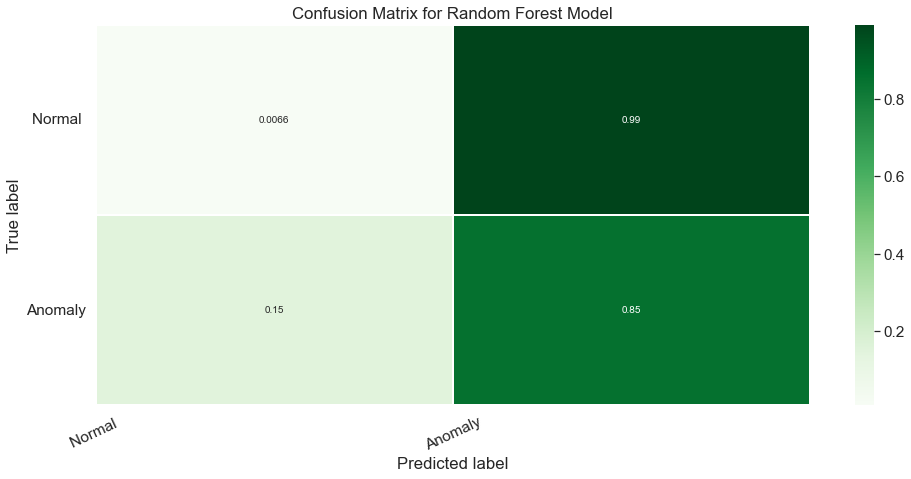

In [15]:
ypredict = rf.predict(xtest)
# yvalid
print('Precisão do modelo: {}' .format(accuracy_score(ytest,ypredict)))

matrix = confusion_matrix(ytest, ypredict)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot
class_names = ['Normal ', 'Anomaly']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Random Forest Model')
plt.show()

In [14]:
# avaliação da performance (dados de treino)
rf.report(xtrain, ytrain)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5975
           1       1.00      1.00      1.00      5975

    accuracy                           1.00     11950
   macro avg       1.00      1.00      1.00     11950
weighted avg       1.00      1.00      1.00     11950



In [15]:
# avaliação da performance (dados de teste)
rf.report(xtest, ytest)

              precision    recall  f1-score   support

           0       1.00      0.99      0.99     35631
           1       0.94      1.00      0.97      8433

    accuracy                           0.99     44064
   macro avg       0.97      0.99      0.98     44064
weighted avg       0.99      0.99      0.99     44064



In [16]:
# avaliação da performance (dados de validação)
rf.report(xvalid,yvalid)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     66020
           1       0.83      0.95      0.88        76

    accuracy                           1.00     66096
   macro avg       0.91      0.97      0.94     66096
weighted avg       1.00      1.00      1.00     66096



Random Forest usando Dataset normalizado 

In [91]:
# criação e treinamento do modelo
rf = models.RandForestClass(n_estimators = 3000, 
    criterion = 'entropy', bootstrap = True, max_depth = 55, max_features= 0.15) #TOP 

rf.fit(xtrain_norm, ytrain_norm) #12m51s
#MaxDepth 40 - Predict 0.9910357661583151
#MaxDepth 35 - Predict 0.9909903776325345
#MaxDepth 45 - Predict 0.9910584604212055
#MaxDepth 55 - Predict 0.9910584604212055
#MaxDepth 50 - Predict 0.9910130718954249
#MaxDepth 45 - max_features 0.1  -  Predict 0.9910584604212055

RandForestClass(criterion='entropy', max_depth=55, max_features=0.15,
                n_estimators=3000)

In [62]:
# plt.plot(ytest_norm)
# # plt.plot(yvalid_norm)

# plt.plot(ypredict_test_norm)

# plt.plot(ypredict_valid_norm)
# ytest_norm.reset_index(inplace=False, drop=False)

In [92]:
# avaliação da performance (dados de treino)
rf.report(xtrain_norm, ytrain_norm)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    104185
           1       1.00      1.00      1.00      5975

    accuracy                           1.00    110160
   macro avg       1.00      1.00      1.00    110160
weighted avg       1.00      1.00      1.00    110160



In [93]:
# avaliação da performance (dados de teste)
rf.report(xtest_norm, ytest_norm)

              precision    recall  f1-score   support

           0       1.00      0.99      0.99     35631
           1       0.96      1.00      0.98      8433

    accuracy                           0.99     44064
   macro avg       0.98      0.99      0.99     44064
weighted avg       0.99      0.99      0.99     44064



In [94]:
# avaliação da performance (dados de validação)
rf.report(xvalid_norm,yvalid_norm)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     66020
           1       1.00      0.95      0.97        76

    accuracy                           1.00     66096
   macro avg       1.00      0.97      0.99     66096
weighted avg       1.00      1.00      1.00     66096



Precisão do modelo: 0.9912400145243282


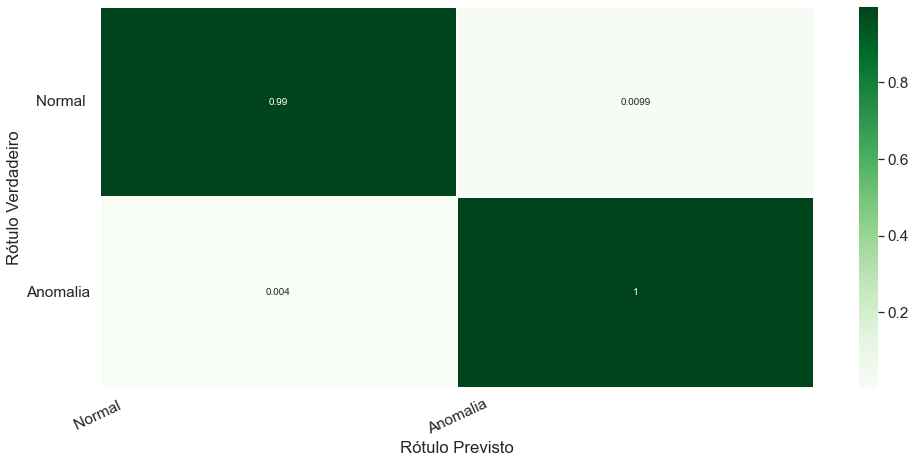

In [95]:
ypredict_test_norm = rf.predict(xtest_norm)
print('Precisão do modelo: {}'.format(accuracy_score(ytest_norm,ypredict_test_norm)))

matrix = confusion_matrix(ytest_norm, ypredict_test_norm)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot
class_names = ['Normal ', 'Anomalia']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Rótulo Previsto')
plt.ylabel('Rótulo Verdadeiro')
# plt.title('Matriz de Confusão para o Modelo de Random Forest')
plt.show()

Precisão do modelo: 0.9999394819656258


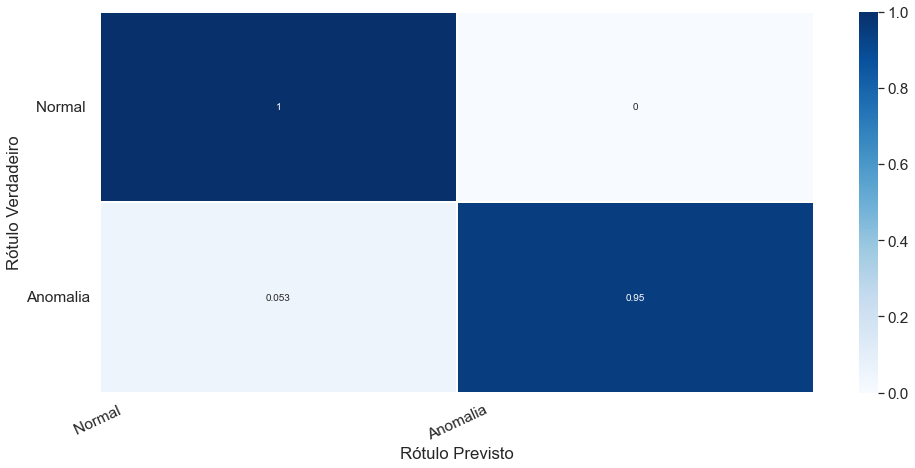

In [96]:
ypredict_valid_norm = rf.predict(xvalid_norm)
print('Precisão do modelo: {}'.format(accuracy_score(yvalid_norm,ypredict_valid_norm)))

matrix = confusion_matrix(yvalid_norm, ypredict_valid_norm)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Blues, linewidths=0.2)

# Add labels to the plot
class_names = ['Normal ', 'Anomalia']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Rótulo Previsto')
plt.ylabel('Rótulo Verdadeiro')
# plt.title('Matriz de Confusão para o Modelo de Random Forest')
plt.show()

# OLDS 1

In [33]:
# full_df = pd.DataFrame()
# # for key, values in tqdm(Df_v2_down.items()):
# for key, values in tqdm(Df_v2_down.items()):
    
#     partial_df = pd.DataFrame()
#     for k in values.keys():
#         partial_df[k] = values[k]

#     if full_df.empty:
#         full_df = partial_df
#     else:
#         full_df = pd.concat([full_df, partial_df])

# full_df.reset_index(inplace=True, drop=True)

In [34]:
# tam
# Df_v2_down.items()
# values.keys()
# partial_df

In [35]:
# len(Df_v2['sensor_00'])
# tam
# len(Df_v2['sensor_00'])
# sensors
# len(Df_v2[sensors])
# Df_v2[sensors].name
# tam_pass
# Cols=Df_v2.columns
# Cols


In [36]:
# Df_v3.plot(subplots =True, sharex = True, figsize = (20,50))

In [37]:
Df_v2['b_machine_status'] = Df_v2['machine_status'].apply(lambda x: x if x == 'NORMAL' else 'ANOMALY')
Df_v2['n_machine_status'] = Df_v2['machine_status'].apply(lambda x: 1 if x=='ANOMALY' else 0)

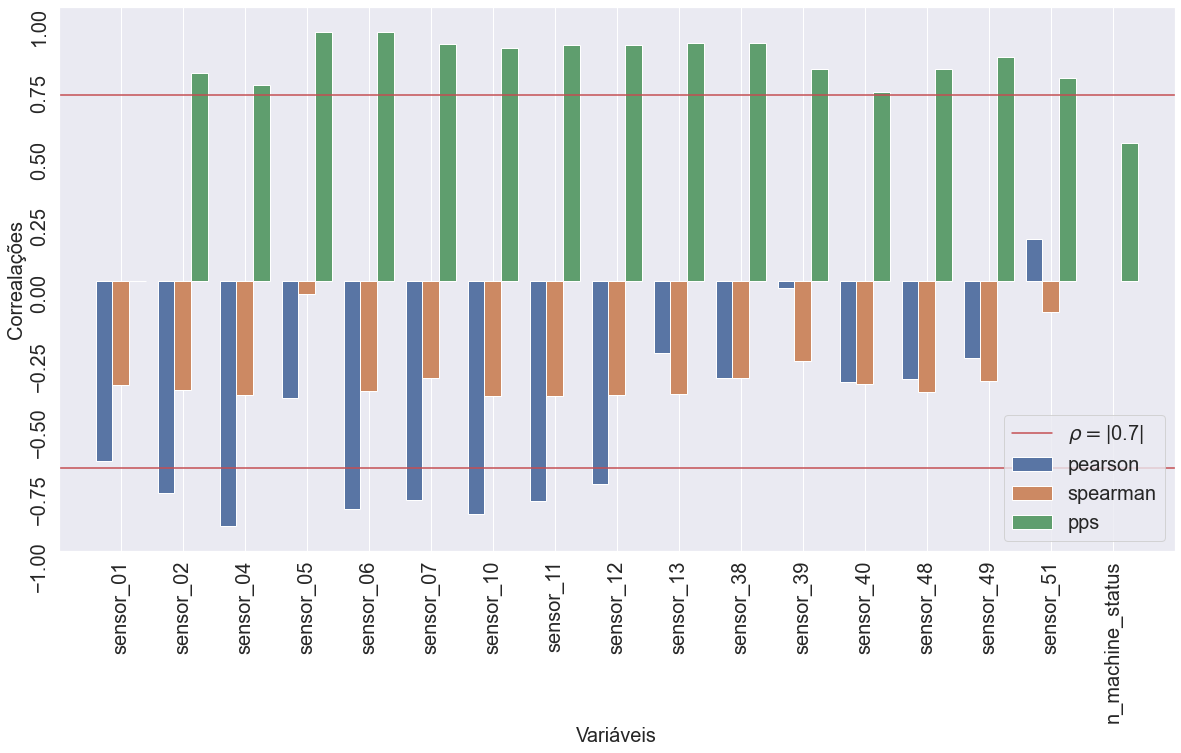

In [38]:
plots.corr_plot(Df_v2, th=.7)

Correlação de Spearman, Pearson e PPS: Com a correlação feita acima, é possível selecionar os sensores que possuem uma correlação acima de 70% e ignorar os restantes.
Os sensores são: ['00','01','02','04','05','06','07','08','10','11','12','13','38','40','48','49','50','51']

In [39]:
# verificação da correlação multivariada
plots.mvar_corr(Df_v2, th=.75)

KeyError: "['sensor_15'] not found in axis"

Correlação Multivariada: 
Com a correlação das importâncias realizada acima, é possível filtrar novamente as melhores variáveis para o problema.
Os sensores são: ['00', '01', '03,'04','05','10','11','13','50','51']

In [ ]:
# verificação das variáveis redundantes
# ['00', '01', '03,'04','05','10','11','13','33','50','51']
num_sensors = ['00', '01', '02', '03', '04', '05', '06', '07', '08', '10', '11', '12', '14', '13', '38', '40', '48', '49', '50', '51']
selected_sensors = [f'sensor_{i}' for i in num_sensors]
plots.redundant_features(Df_v2, sensors=selected_sensors)

KeyError: "['sensor_00', 'sensor_03', 'sensor_08', 'sensor_14', 'sensor_50'] not in index"

In [ ]:
null_list = Df_v2.isnull().sum()
(null_list[null_list != 0] / Df_v2.shape[0])*100

sensor_00      4.633261
sensor_01      0.167484
sensor_02      0.008624
sensor_03      0.008624
sensor_04      0.008624
sensor_05      0.008624
sensor_06      2.177741
sensor_07      2.474129
sensor_08      2.317992
sensor_09      2.085603
sensor_10      0.008624
sensor_11      0.008624
sensor_12      0.008624
sensor_13      0.008624
sensor_14      0.009532
sensor_15    100.000000
sensor_16      0.014070
sensor_17      0.020879
sensor_18      0.020879
sensor_19      0.007262
sensor_20      0.007262
sensor_21      0.007262
sensor_22      0.018609
sensor_23      0.007262
sensor_24      0.007262
sensor_25      0.016340
sensor_26      0.009078
sensor_27      0.007262
sensor_28      0.007262
sensor_29      0.032680
sensor_30      0.118464
sensor_31      0.007262
sensor_32      0.030864
sensor_33      0.007262
sensor_34      0.007262
sensor_35      0.007262
sensor_36      0.007262
sensor_37      0.007262
sensor_38      0.012255
sensor_39      0.012255
sensor_40      0.012255
sensor_41      0

In [ ]:
# exclusão dos sensores 0, 15 e 50

pdata = Df_v2_norm.copy()
# pdata['machine_status'] = Df_v2['machine_status'].copy()
# pdata['b_machine_status'] = Df_v2['b_machine_status'].copy()
# pdata.drop(columns=['sensor_00', 'sensor_50'], inplace=True)

# interpolação dos demais sensores
pdata.interpolate(axis=0, inplace=True)


pdata['timestamp'] = Df_v2['timestamp'].copy()

ValueError: Invalid fill method. Expecting pad (ffill) or backfill (bfill). Got linear

In [ ]:
# Df_v3=Df_v2
Df_v3=pdata


# Df_v2[Cols[3]].loc[Df_v2[Cols[3]].isnull()]

# for Title in Cols:
    # for Value in range(len(Df_v2[Title])):
    #     if Df_v2[Title][Value] == 'NaN' :
    #         Df_v2[Title][Value].interpolate(method ='linear', limit_direction ='forward')
    
    # if Df_v2[Title].isnull().sum() > 0 :
    #    ContNull = Df_v2[Title].isnull().sum()
    #     for id in range(ContNull):
    #         Df_v2[Title].loc[Df_v2[Title].isnull()]

In [ ]:
Df_v3['n_machine_status'] = Df_v3['machine_status'].apply(lambda x: 1 if x=='ANOMALY' else 0)

In [ ]:
Df_v3

,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_10,sensor_11,...,sensor_13,sensor_38,sensor_40,sensor_48,sensor_49,sensor_51,machine_status,b_machine_status,timestamp,n_machine_status
0,47.09201,53.211800,46.310760,634.375000,76.45975,13.41146,16.13136,15.56713,37.22740,47.52422,...,1.681353,40.36458,70.57291,157.9861,67.70834,201.3889,NORMAL,NORMAL,2018-04-01 00:00:00,0
1,47.09201,53.211800,46.310760,634.375000,76.45975,13.41146,16.13136,15.56713,37.22740,47.52422,...,1.681353,40.36458,70.57291,157.9861,67.70834,201.3889,NORMAL,NORMAL,2018-04-01 00:01:00,0
2,47.35243,53.211800,46.397570,638.888900,73.54598,13.32465,16.03733,15.61777,37.86777,48.17723,...,1.708474,41.40625,69.53125,155.9606,67.12963,203.7037,NORMAL,NORMAL,2018-04-01 00:02:00,0
3,47.09201,53.168400,46.397568,628.125000,76.98898,13.31742,16.24711,15.69734,38.57977,48.65607,...,1.579427,41.92708,72.13541,155.9606,66.84028,203.1250,NORMAL,NORMAL,2018-04-01 00:03:00,0
4,47.13541,53.211800,46.397568,636.458300,76.58897,13.35359,16.21094,15.69734,39.48939,49.06298,...,1.683831,42.70833,76.82291,158.2755,66.55093,201.3889,NORMAL,NORMAL,2018-04-01 00:04:00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220315,47.69965,50.520830,43.142361,634.722229,64.59095,15.11863,16.65220,15.65393,43.17085,54.16052,...,13.265320,47.13541,71.61458,212.3843,153.64580,231.1921,NORMAL,NORMAL,2018-08-31 23:55:00,0
220316,47.69965,50.564240,43.142361,630.902771,65.83363,15.15480,16.70284,15.65393,43.21038,54.52602,...,13.242270,46.87500,73.17708,213.8310,156.25000,231.1921,NORMAL,NORMAL,2018-08-31 23:56:00,0
220317,47.69965,50.520830,43.142361,625.925903,67.29445,15.08970,16.70284,15.69734,43.12836,55.11779,...,13.188660,46.09375,77.08333,217.3032,155.38190,232.0602,NORMAL,NORMAL,2018-08-31 23:57:00,0
220318,47.69965,50.520832,43.142361,635.648100,65.09175,15.11863,16.56539,15.74074,42.35746,55.99321,...,13.173460,45.83333,78.64583,222.5116,153.93520,234.0856,NORMAL,NORMAL,2018-08-31 23:58:00,0


In [ ]:
# separação em conjunto de treino e teste
x = Df_v3.drop(columns=['n_machine_status','b_machine_status','machine_status','timestamp'])
y = Df_v3['b_machine_status'].apply(lambda x: 1 if x=='ANOMALY' else 0)

xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=.2, random_state=42)

In [ ]:
xtrain

,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_10,sensor_11,sensor_12,sensor_14,sensor_13,sensor_38,sensor_40,sensor_48,sensor_49,sensor_51
18599,49.739582,51.215270,43.229164,622.222200,77.579380,14.113140,16.131360,15.704570,35.191670,46.570940,26.16499,408.7038,6.995106,44.791660,82.291660,87.09491,49.189820,96.64352
82098,48.871525,53.689240,44.791664,635.879600,72.720120,13.389760,15.914350,15.292240,52.129490,37.433190,33.11659,420.0681,1.896241,42.968750,74.739580,123.26390,48.321758,202.54630
142571,45.529510,52.560760,47.482635,625.115700,94.968540,14.185470,15.661170,15.415220,44.426290,48.582900,33.36489,420.1288,16.635260,67.447910,66.666660,228.29860,67.129630,208.33330
94587,49.696180,53.689240,43.793400,624.305500,83.052330,13.592300,15.704570,15.075230,47.475800,36.381370,29.76296,420.3753,1.188905,58.333330,62.500000,81.01852,53.530094,197.04860
31777,49.652770,54.730900,46.223957,642.129600,79.424710,13.650170,16.210940,15.820310,42.298690,53.053830,35.13510,421.7224,3.141851,47.916660,66.666660,74.07407,51.215280,203.99310
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119879,47.482640,49.913190,41.927080,640.162000,78.353750,14.171010,15.856480,15.147570,45.794250,40.311930,30.90305,421.5220,0.823710,53.125000,67.447910,62.78935,45.428242,1000.00000
103694,48.046880,50.086803,40.364582,628.240700,73.568560,14.033560,15.625000,15.335650,51.196000,38.121760,24.79114,419.6862,0.650733,61.718750,73.177080,95.48611,52.372680,197.91670
131932,35.026039,37.369789,34.895832,3.336227,99.999878,0.028935,0.036169,0.028935,0.221354,0.034722,0.00000,424.8532,0.000000,28.645832,28.385416,31.82870,31.828703,1000.00000
146867,42.968750,49.522570,44.314236,636.689800,79.808570,14.062500,16.160300,15.567130,48.948490,52.887850,36.05464,421.4069,1.931578,55.989580,69.270830,144.96530,82.465280,268.22920


In [ ]:
# balanceamento dos dados de treino
train_set = pd.concat([xtrain, ytrain], axis='columns')
an_df = train_set.groupby('b_machine_status').get_group(1)
n_df = train_set.groupby('b_machine_status').get_group(0).sample(n=an_df.shape[0], random_state=42)
train_set = shuffle(pd.concat([n_df, an_df]))

xtrain = train_set.drop(columns='b_machine_status')
ytrain = train_set['b_machine_status']

In [ ]:
# criação e treinamento do modelo
rf = models.RandForestClass()
rf.fit(xtrain, ytrain)

RandForestClass()

In [ ]:
# avaliação da performance (dados de treino)
rf.report(xtrain, ytrain)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     11663
           1       1.00      1.00      1.00     11663

    accuracy                           1.00     23326
   macro avg       1.00      1.00      1.00     23326
weighted avg       1.00      1.00      1.00     23326



In [ ]:
# avaliação da performance (dados de teste)
rf.report(xtest, ytest)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     41243
           1       0.98      1.00      0.99      2821

    accuracy                           1.00     44064
   macro avg       0.99      1.00      1.00     44064
weighted avg       1.00      1.00      1.00     44064



# teste com outro modelo e código

In [ ]:
#Teste

normal_indices = Df_v2[Df_v2['n_machine_status'] == 0].index   # Get the record numbers of non-diab cases
normal = len(Df_v2[Df_v2['n_machine_status'] == 0])             # how many non-diab cases
print(normal)



220320


In [ ]:
anomaly_indices = Df_v3[Df_v3['n_machine_status'] == 1].index       # record number of the diabeteics cases
anomaly = len(Df_v3[Df_v3['n_machine_status'] == 1])                # how many diabetic cases
print(anomaly)



0


In [ ]:
random_indices = np.random.choice( normal_indices, normal - 200 , replace=False)    #Randomly pick up 200 non-diab indices
down_sample_indices = np.concatenate([anomaly_indices,random_indices])  # combine the 200 non-diab indices with diab indices
pima_df_down_sample = Df_v3.loc[down_sample_indices]  # Extract all those records for diab and non-diab to create new set
pima_df_down_sample.drop(columns='timestamp',inplace=True)
pima_df_down_sample.shape
pima_df_down_sample.groupby(["machine_status"]).count()  # look at the class distribution after downsample



,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_10,sensor_11,sensor_12,sensor_14,sensor_13,sensor_38,sensor_40,sensor_48,sensor_49,sensor_51,b_machine_status,n_machine_status
machine_status,,,,,,,,,,,,,,,,,,,,
BROKEN,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7
NORMAL,205646,205646,205646,205646,205646,205646,205646,205646,205646,205646,205646,205646,205646,205646,205646,205646,205646,205646,205646,205646
RECOVERING,14467,14467,14467,14467,14467,14467,14467,14467,14467,14467,14467,14467,14467,14467,14467,14467,14467,14467,14467,14467


In [ ]:
array = pima_df_down_sample.values
X = array[:,0:7] # select all rows and first 8 columns which are the attributes
Y = array[:,8]   # select all rows and the 8th column which is the classification "Yes", "No" for diabeties
test_size = 0.30 # taking 70:30 training and test set
seed = 7  # Random numbmer seeding for reapeatability of the code
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)
type(X_train)

numpy.ndarray

In [ ]:
print('After DownSampling, the shape of X_train: {}'.format(X_train.shape))
print('After DownSampling, the shape of X_test: {} \n'.format(X_test.shape))

After DownSampling, the shape of X_train: (154084, 7)
After DownSampling, the shape of X_test: (66036, 7) 



In [ ]:
X_train

array([[47.9600677490234, 50.30382, 44.704860687255895, ..., 70.85529,
        14.74971, 16.16753],
       [46.09375, 53.4722213745117, 45.2256927490234, ..., 84.28413,
        14.677370000000002, 16.16753],
       [46.52777, 50.13021, 44.4878463745117, ..., 84.20781,
        14.677370000000002, 16.21094],
       ...,
       [46.31076, 52.8211784362793, 44.8784713745117, ..., 69.9446,
        14.39525, 16.70284],
       [50.13021, 54.25346999999999, 45.74652, ..., 69.19762, 13.56337,
        16.13136],
       [43.4895820617676, 50.173610687255895, 43.8368034362793, ...,
        77.98845, 13.96123, 16.06626]], dtype=object)

In [ ]:
# Fit the model on 30%
model = LogisticRegression()
model.fit(X_train, Y_train)
# y_predict = model.predict(X_test)
# model_score = model.score(X_test, Y_test)
# print(model_score)
# print(metrics.confusion_matrix(y_test, y_predict))
# print(metrics.classification_report(y_test, y_predict))

ValueError: Unknown label type: 'unknown'

# # OLDS

In [ ]:
# Df_v2[Cols[1]].loc[Df_v2[Cols[1]].isnull()]
# Df_v2[Cols[1]].iloc[17157]

# plt.plot(Df_v3['sensor_13'][:100])


In [ ]:
# sns.heatmap(Df_v3.isnull(),cbar=False,cmap='viridis')

In [ ]:
# sensors = Df_v3[:0]

In [ ]:
# sensors.info()

In [ ]:
# mudança no formato da coluna "timestamp"
# Df_v3['timestamp'] = Df_v3['timestamp'].astype('datetime64')

# visualização temporal dos dados
# num_sensors2=['13', '14']
# selected_sensors2 = [f'sensor_{i}' for i in num_sensors2]
plots.sensor_plot(Df_v2, sensors=['sensor_14'])

# 

Error in callback <function flush_figures at 0x000002E19BDCC8B0> (for post_execute):


KeyboardInterrupt: 

In [ ]:
# Df_v3['b_machine_status'] = Df_v3['machine_status'].apply(lambda x: x if x == 'NORMAL' else 'ANOMALY')

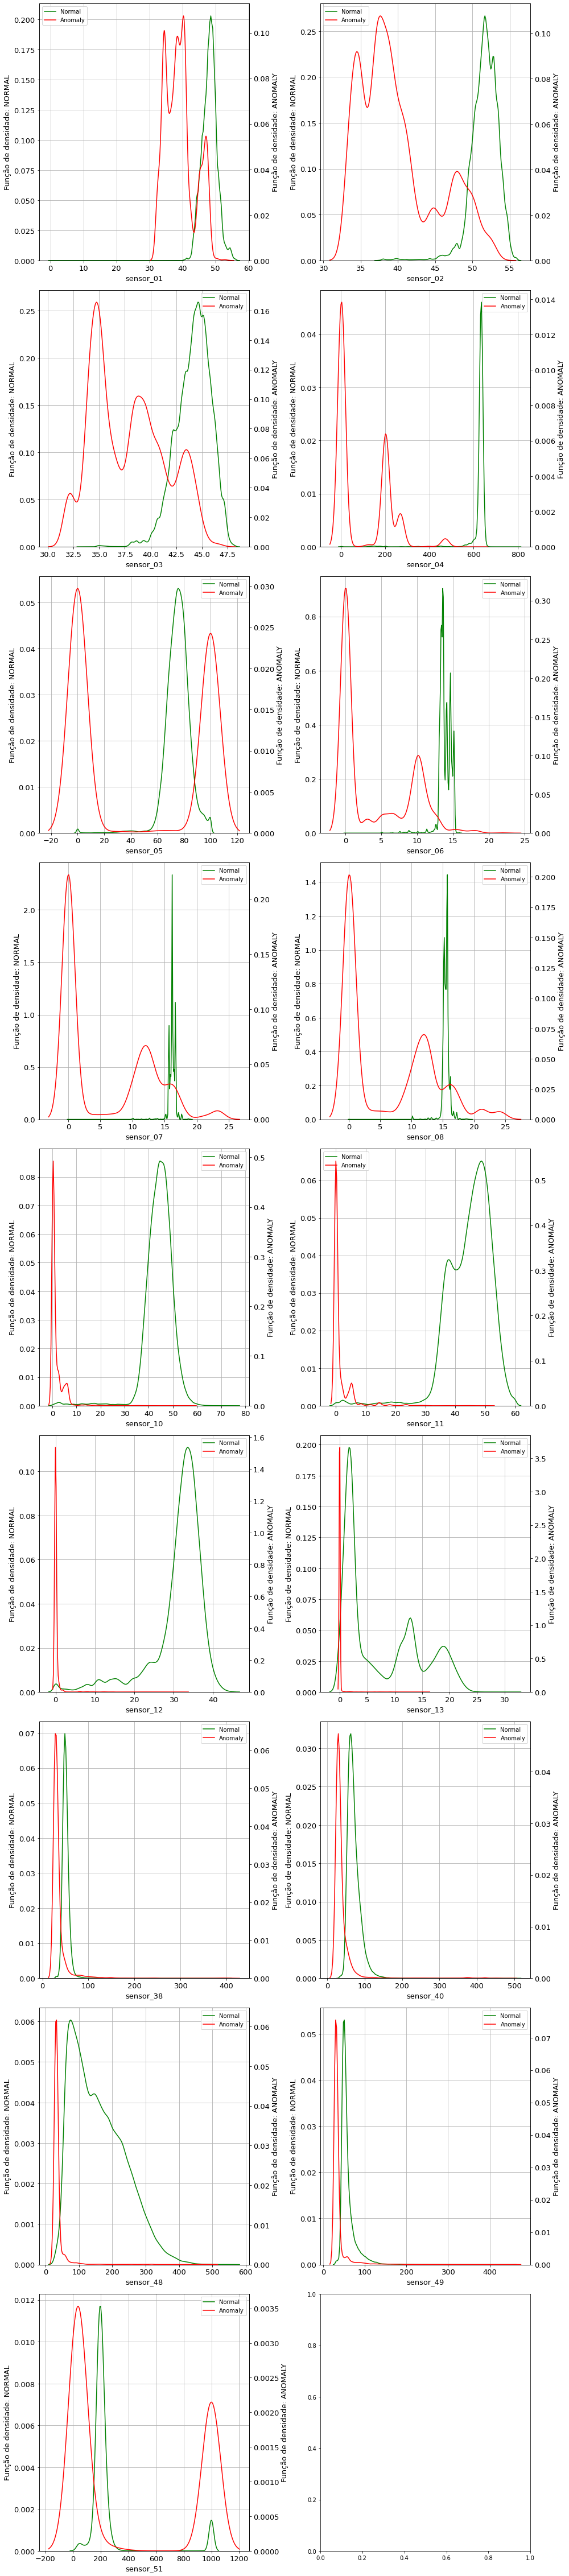

In [ ]:
# verificação das distribuições dos sensores
plots.dist_plot(Df_v3, sensors=selected_sensors2)

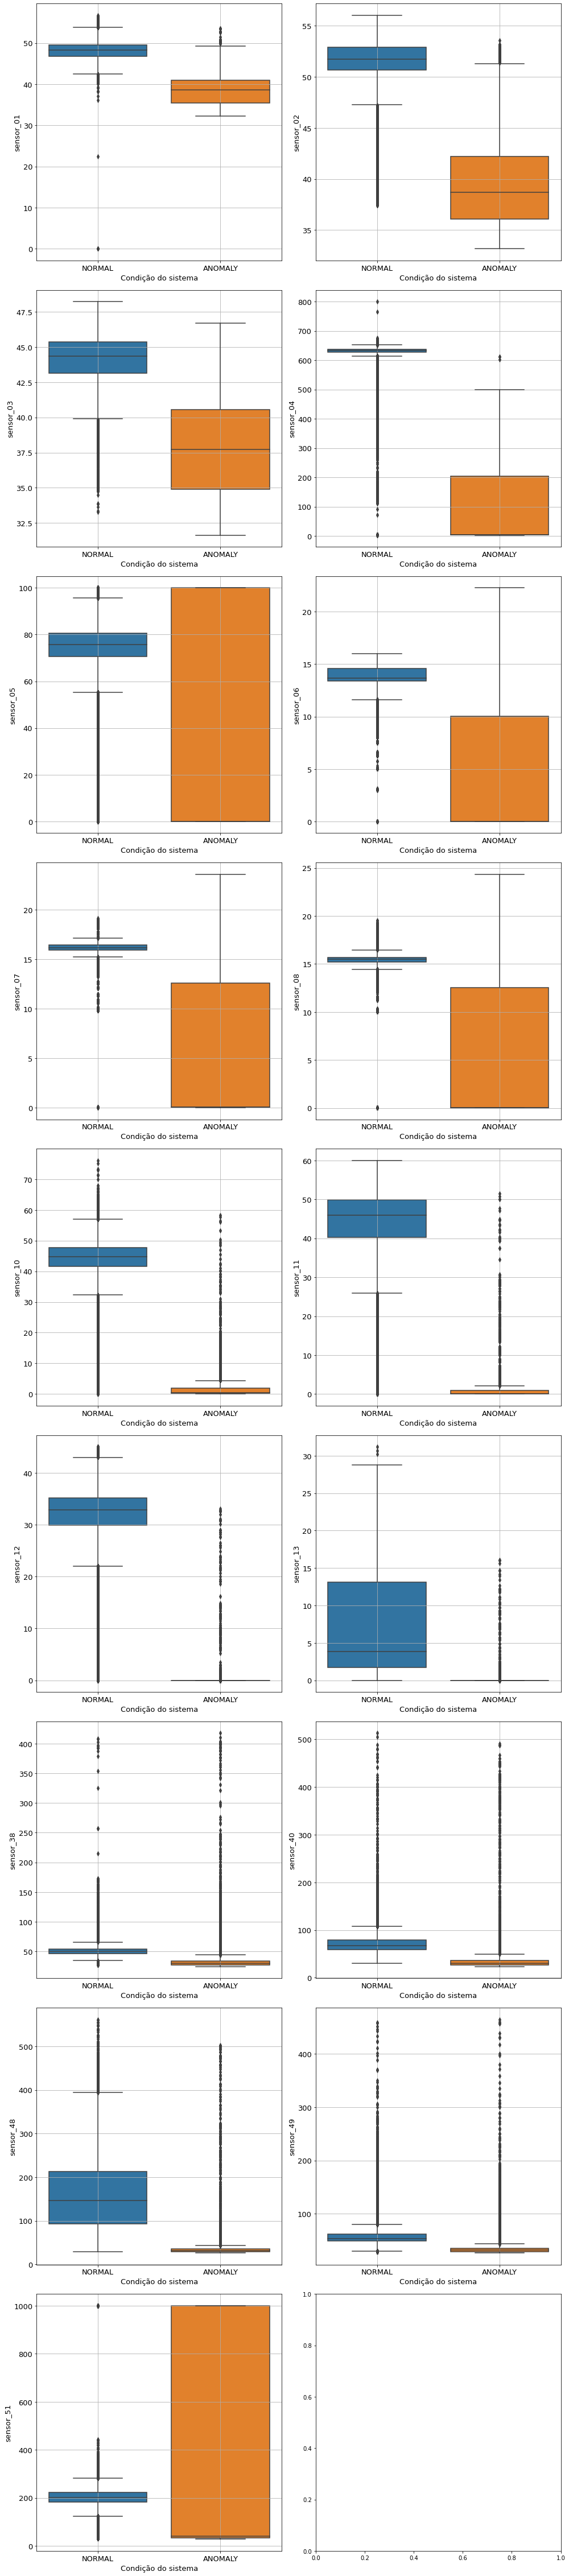

In [ ]:
plots.boxplot(Df_v3, sensors=selected_sensors2)

In [ ]:
Cols=Df_v3.columns
# Df_v3['sensor_00'][0:10].mean()
x=0
# for n in Cols:
#     size = len(Df_v3[n])
#     for m in range(9,size,10):
#         test[n] = Df_v3[n][x:m].mean()
#         x=x+m

In [ ]:
# Df_v4.plot(subplots =True, sharex = True, figsize = (20,50))

In [ ]:
# for m in range(len(Df_v3['machine_status'])):
#     if Df_v3['machine_status'][m] == 'NORMAL':
#         Df_v3 = 0
#     if Df_v3['machine_status'][m] == 'BROKEN':
#         Df_v3 = 1
#     if Df_v3['machine_status'][m] == 'RECOVERING':
#         Df_v3 = 2
    


In [ ]:
Df_v3

,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_10,sensor_11,sensor_12,sensor_13,sensor_38,sensor_40,sensor_48,sensor_49,sensor_51,machine_status,b_machine_status,timestamp
0,47.09201,53.211800,46.310760,634.375000,76.45975,13.41146,16.13136,15.56713,37.22740,47.52422,31.11716,1.681353,40.36458,70.57291,157.9861,67.70834,201.3889,NORMAL,NORMAL,2018-04-01 00:00:00
1,47.09201,53.211800,46.310760,634.375000,76.45975,13.41146,16.13136,15.56713,37.22740,47.52422,31.11716,1.681353,40.36458,70.57291,157.9861,67.70834,201.3889,NORMAL,NORMAL,2018-04-01 00:01:00
2,47.35243,53.211800,46.397570,638.888900,73.54598,13.32465,16.03733,15.61777,37.86777,48.17723,32.08894,1.708474,41.40625,69.53125,155.9606,67.12963,203.7037,NORMAL,NORMAL,2018-04-01 00:02:00
3,47.09201,53.168400,46.397568,628.125000,76.98898,13.31742,16.24711,15.69734,38.57977,48.65607,31.67221,1.579427,41.92708,72.13541,155.9606,66.84028,203.1250,NORMAL,NORMAL,2018-04-01 00:03:00
4,47.13541,53.211800,46.397568,636.458300,76.58897,13.35359,16.21094,15.69734,39.48939,49.06298,31.95202,1.683831,42.70833,76.82291,158.2755,66.55093,201.3889,NORMAL,NORMAL,2018-04-01 00:04:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220315,47.69965,50.520830,43.142361,634.722229,64.59095,15.11863,16.65220,15.65393,43.17085,54.16052,38.05424,13.265320,47.13541,71.61458,212.3843,153.64580,231.1921,NORMAL,NORMAL,2018-08-31 23:55:00
220316,47.69965,50.564240,43.142361,630.902771,65.83363,15.15480,16.70284,15.65393,43.21038,54.52602,38.53485,13.242270,46.87500,73.17708,213.8310,156.25000,231.1921,NORMAL,NORMAL,2018-08-31 23:56:00
220317,47.69965,50.520830,43.142361,625.925903,67.29445,15.08970,16.70284,15.69734,43.12836,55.11779,38.52678,13.188660,46.09375,77.08333,217.3032,155.38190,232.0602,NORMAL,NORMAL,2018-08-31 23:57:00
220318,47.69965,50.520832,43.142361,635.648100,65.09175,15.11863,16.56539,15.74074,42.35746,55.99321,38.89159,13.173460,45.83333,78.64583,222.5116,153.93520,234.0856,NORMAL,NORMAL,2018-08-31 23:58:00


In [ ]:
# Cols=Df_v3.columns
# # Df_v3['sensor_00'][0:10].mean()
# test={}
# x=0
# cont=0
# for n in Cols:
#     if n == 'timestamp':
#         pass
#     else:
#         size = len(Df_v3[n])
#         for m in range(9,size,10):
#             test[cont] = {f'{n}',Df_v3[n][x:m].mean()}
#             cont=cont+1
#             x=m+1

In [ ]:
# test
Cols
# x
# n == 'timestamp'

## Transformando em .Parquet

In [ ]:
Df_v3.to_parquet('F:\FACUL\FACULDADE\PG1\Dados\Dados_Pump.parquet', index=False)

## Dataframe tratado

In [ ]:
path='F:\FACUL\FACULDADE\PG1\Dados'
Df_final = pd.read_parquet(path+r'\Dados_Pump.parquet')
Df_final

,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_10,sensor_11,sensor_12,sensor_13,sensor_38,sensor_40,sensor_48,sensor_49,sensor_51,machine_status,b_machine_status,timestamp
0,47.09201,53.211800,46.310760,634.375000,76.45975,13.41146,16.13136,15.56713,37.22740,47.52422,31.11716,1.681353,40.36458,70.57291,157.9861,67.70834,201.3889,NORMAL,NORMAL,2018-04-01 00:00:00
1,47.09201,53.211800,46.310760,634.375000,76.45975,13.41146,16.13136,15.56713,37.22740,47.52422,31.11716,1.681353,40.36458,70.57291,157.9861,67.70834,201.3889,NORMAL,NORMAL,2018-04-01 00:01:00
2,47.35243,53.211800,46.397570,638.888900,73.54598,13.32465,16.03733,15.61777,37.86777,48.17723,32.08894,1.708474,41.40625,69.53125,155.9606,67.12963,203.7037,NORMAL,NORMAL,2018-04-01 00:02:00
3,47.09201,53.168400,46.397568,628.125000,76.98898,13.31742,16.24711,15.69734,38.57977,48.65607,31.67221,1.579427,41.92708,72.13541,155.9606,66.84028,203.1250,NORMAL,NORMAL,2018-04-01 00:03:00
4,47.13541,53.211800,46.397568,636.458300,76.58897,13.35359,16.21094,15.69734,39.48939,49.06298,31.95202,1.683831,42.70833,76.82291,158.2755,66.55093,201.3889,NORMAL,NORMAL,2018-04-01 00:04:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220315,47.69965,50.520830,43.142361,634.722229,64.59095,15.11863,16.65220,15.65393,43.17085,54.16052,38.05424,13.265320,47.13541,71.61458,212.3843,153.64580,231.1921,NORMAL,NORMAL,2018-08-31 23:55:00
220316,47.69965,50.564240,43.142361,630.902771,65.83363,15.15480,16.70284,15.65393,43.21038,54.52602,38.53485,13.242270,46.87500,73.17708,213.8310,156.25000,231.1921,NORMAL,NORMAL,2018-08-31 23:56:00
220317,47.69965,50.520830,43.142361,625.925903,67.29445,15.08970,16.70284,15.69734,43.12836,55.11779,38.52678,13.188660,46.09375,77.08333,217.3032,155.38190,232.0602,NORMAL,NORMAL,2018-08-31 23:57:00
220318,47.69965,50.520832,43.142361,635.648100,65.09175,15.11863,16.56539,15.74074,42.35746,55.99321,38.89159,13.173460,45.83333,78.64583,222.5116,153.93520,234.0856,NORMAL,NORMAL,2018-08-31 23:58:00


In [ ]:
Df_final.rename({'sensor_01':'Motor Frequency A','sensor_02':'Motor Frequency B','sensor_03':'Motor Frequency C',
'sensor_04':'Motor Speed','sensor_05':'Motor Current','sensor_06':'Motor Active Power','sensor_07':'Motor Apparent Power','sensor_08':'Motor Reactive Power',
'sensor_10':'Motor Phase Current A','sensor_11':'Motor Phase Current B','sensor_12':'Motor Phase Current C', 'sensor_13':'Motor Coupling Vibration', 
'sensor_38' : 'Pump Lube Oil Return Temp', 'sensor_40': 'Pump Thrust Bearing Active Temp', 'sensor_48': 'Pump Inlet Pressure', 'sensor_49':'Pump Temp Unknown', 'sensor_50':'Pump Discharge Pressure 1', 
'sensor_51':'Pump Discharge Pressure 2' }
,axis=1,inplace=True)

In [ ]:
Df_final

,Motor Frequency A,Motor Frequency B,Motor Frequency C,Motor Speed,Motor Current,Motor Active Power,Motor Apparent Power,Motor Reactive Power,Motor Phase Current A,Motor Phase Current B,Motor Phase Current C,Motor Coupling Vibration,Pump Lube Oil Return Temp,Pump Thrust Bearing Active Temp,Pump Inlet Pressure,Pump Temp Unknown,Pump Discharge Pressure 2,machine_status,b_machine_status,timestamp
0,47.09201,53.211800,46.310760,634.375000,76.45975,13.41146,16.13136,15.56713,37.22740,47.52422,31.11716,1.681353,40.36458,70.57291,157.9861,67.70834,201.3889,NORMAL,NORMAL,2018-04-01 00:00:00
1,47.09201,53.211800,46.310760,634.375000,76.45975,13.41146,16.13136,15.56713,37.22740,47.52422,31.11716,1.681353,40.36458,70.57291,157.9861,67.70834,201.3889,NORMAL,NORMAL,2018-04-01 00:01:00
2,47.35243,53.211800,46.397570,638.888900,73.54598,13.32465,16.03733,15.61777,37.86777,48.17723,32.08894,1.708474,41.40625,69.53125,155.9606,67.12963,203.7037,NORMAL,NORMAL,2018-04-01 00:02:00
3,47.09201,53.168400,46.397568,628.125000,76.98898,13.31742,16.24711,15.69734,38.57977,48.65607,31.67221,1.579427,41.92708,72.13541,155.9606,66.84028,203.1250,NORMAL,NORMAL,2018-04-01 00:03:00
4,47.13541,53.211800,46.397568,636.458300,76.58897,13.35359,16.21094,15.69734,39.48939,49.06298,31.95202,1.683831,42.70833,76.82291,158.2755,66.55093,201.3889,NORMAL,NORMAL,2018-04-01 00:04:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220315,47.69965,50.520830,43.142361,634.722229,64.59095,15.11863,16.65220,15.65393,43.17085,54.16052,38.05424,13.265320,47.13541,71.61458,212.3843,153.64580,231.1921,NORMAL,NORMAL,2018-08-31 23:55:00
220316,47.69965,50.564240,43.142361,630.902771,65.83363,15.15480,16.70284,15.65393,43.21038,54.52602,38.53485,13.242270,46.87500,73.17708,213.8310,156.25000,231.1921,NORMAL,NORMAL,2018-08-31 23:56:00
220317,47.69965,50.520830,43.142361,625.925903,67.29445,15.08970,16.70284,15.69734,43.12836,55.11779,38.52678,13.188660,46.09375,77.08333,217.3032,155.38190,232.0602,NORMAL,NORMAL,2018-08-31 23:57:00
220318,47.69965,50.520832,43.142361,635.648100,65.09175,15.11863,16.56539,15.74074,42.35746,55.99321,38.89159,13.173460,45.83333,78.64583,222.5116,153.93520,234.0856,NORMAL,NORMAL,2018-08-31 23:58:00


In [ ]:
# Df_bearingTemp=pd.DataFrame()
# Df_vibration=pd.DataFrame()
# Df_motorProprieties=pd.DataFrame()
# Df_pumpSpeed=pd.DataFrame()
# Df_pumpFlow=pd.DataFrame()
# Df_pumpLube=pd.DataFrame()
# Df_pumpPressure=pd.DataFrame()


In [ ]:
# Df_v2.unique()
# k=0
# Df_v2.loc[Df_v2['sensor_00']]
# Df_v2.isna().describe()
# Df_final = pd.read_parquet(path+r'\Dados_Pump.parquet')
# for column in tqdm(Cols):
#     if column == 'timestamp' or column == 'machine_status':
#         pass
#     else:
#         name_var = column.split('_')
#         name_var = name_var[1]
#         # try:
#         if name_var >= '01' and name_var <= '12' or name_var >= '14' and name_var <= '17':
#             Df_motorProprieties[f'sensor_{name_var}'] = Df_final[f'sensor_{name_var}']

#         if name_var == '00' or name_var == '13' or name_var == '18':
#             Df_vibration[f'sensor_{name_var}'] = Df_final[f'sensor_{name_var}']

#         if name_var >= '19' and name_var <= '33':
#             Df_pumpSpeed[f'sensor_{name_var}'] = Df_final[f'sensor_{name_var}']

#         if name_var >= '34' and name_var <= '36':
#             Df_pumpFlow[f'sensor_{name_var}'] = Df_final[f'sensor_{name_var}']

#         if name_var >= '37' and name_var <= '39':
#             Df_pumpLube[f'sensor_{name_var}'] = Df_final[f'sensor_{name_var}']

#         if name_var >= '40' and name_var <= '47':
#             Df_bearingTemp[f'sensor_{name_var}'] = Df_final[f'sensor_{name_var}']

#         if name_var >= '48' and name_var <= '51':
#             Df_pumpPressure[f'sensor_{name_var}'] = Df_final[f'sensor_{name_var}']

In [ ]:

# Df_motorProprieties.rename({'sensor_01':'Motor Frequency A','sensor_02':'Motor Frequency B','sensor_03':'Motor Frequency C',
# 'sensor_04':'Motor Speed','sensor_05':'Motor Current','sensor_06':'Motor Active Power','sensor_07':'Motor Apparent Power','sensor_08':'Motor Reactive Power',
# 'sensor_09':'Motor Shaft Power','sensor_10':'Motor Phase Current A','sensor_11':'Motor Phase Current B','sensor_12':'Motor Phase Current C','sensor_14':'Motor Phase Voltage AB',
# 'sensor_16':'Motor Phase Voltage BC','sensor_17':'Motor Phase Voltage CA'},axis=1,inplace=True)

# Df_motorProprieties.head()

# SENSOR_01 - Motor Frequency A
# SENSOR_02 - Motor Frequency B
# SENSOR_03 - Motor Frequency C
# SENSOR_04 - Motor Speed
# SENSOR_05 - Motor Current
# SENSOR_06 - Motor Active Power
# SENSOR_07 - Motor Apparent Power
# SENSOR_08 - Motor Reactive Power
# SENSOR_09 - Motor Shaft Power  
# SENSOR_10 - Motor Phase Current A
# SENSOR_11 - Motor Phase Current B
# SENSOR_12 - Motor Phase Current C
# SENSOR_14 - Motor Phase Voltage AB
# SENSOR_16 - Motor Phase Voltage BC
# SENSOR_17 - Motor Phase Voltage CA

In [ ]:
# Df_vibration.rename({'sensor_00': 'Motor Casing Vibration', 'sensor_13':'Motor Coupling Vibration', 'sensor_18':'Pump Casing Vibration'},axis=1,inplace=True)

# Df_vibration

# SENSOR_00 - Motor Casing Vibration
# SENSOR_13 - Motor Coupling Vibration
# SENSOR_18 - Pump Casing Vibration

In [ ]:
# Df_pumpSpeed.rename({'sensor_19': 'Pump Stage 1 Impeller Speed', 'sensor_20':'Pump Stage 1 Impeller Speed', 'sensor_21':'Pump Stage 1 Impeller Speed', 'sensor_22':'Pump Stage 1 Impeller Speed',
# 'sensor_23':'Pump Stage 1 Impeller Speed', 'sensor_24':'Pump Stage 1 Impeller Speed', 'sensor_25':'Pump Stage 2 Impeller Speed', 'sensor_26':'Pump Stage 2 Impeller Speed', 
# 'sensor_27':'Pump Stage 2 Impeller Speed', 'sensor_28':'Pump Stage 2 Impeller Speed', 'sensor_29':'Pump Stage 2 Impeller Speed', 'sensor_30':'Pump Stage 2 Impeller Speed',
# 'sensor_31':'Pump Stage 2 Impeller Speed', 'sensor_32':'Pump Stage 2 Impeller Speed', 'sensor_33':'Pump Stage 2 Impeller Speed'},axis=1,inplace=True)

# Df_pumpSpeed.head()

# SENSOR_19 - Pump Stage 1 Impeller Speed
# SENSOR_20 - Pump Stage 1 Impeller Speed
# SENSOR_21 - Pump Stage 1 Impeller Speed
# SENSOR_22 - Pump Stage 1 Impeller Speed
# SENSOR_23 - Pump Stage 1 Impeller Speed
# SENSOR_24 - Pump Stage 1 Impeller Speed
# SENSOR_25 - Pump Stage 2 Impeller Speed
# SENSOR_26 - Pump Stage 2 Impeller Speed
# SENSOR_27 - Pump Stage 2 Impeller Speed
# SENSOR_28 - Pump Stage 2 Impeller Speed
# SENSOR_29 - Pump Stage 2 Impeller Speed
# SENSOR_30 - Pump Stage 2 Impeller Speed
# SENSOR_31 - Pump Stage 2 Impeller Speed
# SENSOR_32 - Pump Stage 2 Impeller Speed
# SENSOR_33 - Pump Stage 2 Impeller Speed

In [ ]:
# Df_pumpFlow.rename({'sensor_34': 'Pump Inlet Flow', 'sensor_35':'Pump Discharge Flow', 'sensor_36':'Pump UNKNOWN'},axis=1,inplace=True)
# Df_pumpFlow

# SENSOR_34 - Pump Inlet Flow
# SENSOR_35 - Pump Discharge Flow
# SENSOR_36 - Pump UNKNOWN

In [ ]:
# Df_bearingTemp.rename({'sensor_40': 'Pump Thrust Bearing Active Temp', 'sensor_41':'Motor Non Drive End Radial Bearing Temp 1', 'sensor_42':'Motor Non Drive End Radial Bearing Temp 2',
# 'sensor_43':'Pump Thrust Bearing Inactive Temp','sensor_44':'Pump Drive End Radial Bearing Temp 1','sensor_45':'Pump non Drive End Radial Bearing Temp 1',
# 'sensor_46':'Pump non Drive End Radial Bearing Temp 2','sensor_47':'Pump Drive End Radial Bearing Temp 2'},axis=1,inplace=True)

# Df_bearingTemp

# SENSOR_40 - Pump Thrust Bearing Active Temp
# SENSOR_41 - Motor Non Drive End Radial Bearing Temp 1
# SENSOR_42 - Motor Non Drive End Radial Bearing Temp 2
# SENSOR_43 - Pump Thrust Bearing Inactive Temp
# SENSOR_44 - Pump Drive End Radial Bearing Temp 1
# SENSOR_45 - Pump non Drive End Radial Bearing Temp 1
# SENSOR_46 - Pump Non Drive End Radial Bearing Temp 2
# SENSOR_47 - Pump Drive End Radial Bearing Temp 2

In [ ]:
# Df_pumpPressure.rename({'sensor_48': 'Pump Inlet Pressure', 'sensor_49':'Pump Temp Unknown', 'sensor_50':'Pump Discharge Pressure 1', 'sensor_51':'Pump Discharge Pressure 2'},axis=1,inplace=True)

# Df_pumpPressure

# SENSOR_48 - Pump Inlet Pressure
# SENSOR_49 - Pump Temp Unknown
# SENSOR_50 - Pump Discharge Pressure 1
# SENSOR_51 - Pump Discharge Pressure 2

In [ ]:
# SENSOR_00 - Motor Casing Vibration
# SENSOR_13 - Motor Coupling Vibration
# SENSOR_18 - Pump Casing Vibration

# SENSOR_01 - Motor Frequency A
# SENSOR_02 - Motor Frequency B
# SENSOR_03 - Motor Frequency C
# SENSOR_04 - Motor Speed
# SENSOR_05 - Motor Current
# SENSOR_06 - Motor Active Power
# SENSOR_07 - Motor Apparent Power
# SENSOR_08 - Motor Reactive Power
# SENSOR_09 - Motor Shaft Power  
# SENSOR_10 - Motor Phase Current A
# SENSOR_11 - Motor Phase Current B
# SENSOR_12 - Motor Phase Current C
# SENSOR_14 - Motor Phase Voltage AB
# SENSOR_16 - Motor Phase Voltage BC
# SENSOR_17 - Motor Phase Voltage CA



# SENSOR_19 - Pump Stage 1 Impeller Speed
# SENSOR_20 - Pump Stage 1 Impeller Speed
# SENSOR_21 - Pump Stage 1 Impeller Speed
# SENSOR_22 - Pump Stage 1 Impeller Speed
# SENSOR_23 - Pump Stage 1 Impeller Speed
# SENSOR_24 - Pump Stage 1 Impeller Speed
# SENSOR_25 - Pump Stage 2 Impeller Speed
# SENSOR_26 - Pump Stage 2 Impeller Speed
# SENSOR_27 - Pump Stage 2 Impeller Speed
# SENSOR_28 - Pump Stage 2 Impeller Speed
# SENSOR_29 - Pump Stage 2 Impeller Speed
# SENSOR_30 - Pump Stage 2 Impeller Speed
# SENSOR_31 - Pump Stage 2 Impeller Speed
# SENSOR_32 - Pump Stage 2 Impeller Speed
# SENSOR_33 - Pump Stage 2 Impeller Speed

# SENSOR_34 - Pump Inlet Flow
# SENSOR_35 - Pump Discharge Flow
# SENSOR_36 - Pump UNKNOWN

# SENSOR_37 - Pump Lube Oil Overhead Reservoir Level
# SENSOR_38 - Pump Lube Oil Return Temp
# SENSOR_39 - Pump Lube Oil Supply Temp

# SENSOR_40 - Pump Thrust Bearing Active Temp
# SENSOR_41 - Motor Non Drive End Radial Bearing Temp 1
# SENSOR_42 - Motor Non Drive End Radial Bearing Temp 2
# SENSOR_43 - Pump Thrust Bearing Inactive Temp
# SENSOR_44 - Pump Drive End Radial Bearing Temp 1
# SENSOR_45 - Pump non Drive End Radial Bearing Temp 1
# SENSOR_46 - Pump Non Drive End Radial Bearing Temp 2
# SENSOR_47 - Pump Drive End Radial Bearing Temp 2

# SENSOR_48 - Pump Inlet Pressure
# SENSOR_49 - Pump Temp Unknown
# SENSOR_50 - Pump Discharge Pressure 1
# SENSOR_51 - Pump Discharge Pressure 2
# Pump Status

## Correlação

In [ ]:
# rs = np.random.RandomState(0)
# df = pd.DataFrame(rs.rand(10, 10))
# corr = Df_v3.corr()
# corr.style.background_gradient(cmap='coolwarm').set_precision(2)
# 'RdBu_r', 'BrBG_r', & PuOr_r are other good diverging colormaps

In [ ]:
# fig, axs = plt.subplots(2,figsize=(30,15))
# # corr2=Df_motorProprieties.corr()
# # corr2.style.background_gradient(cmap='coolwarm').set_precision(2)
# # sns.heatmap(corr2, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
# #             square=True, ax=ax)
# x=range(0,220320,1)
# axs[0].plot(x, Df_pumpFlow[Df_pumpFlow.columns[1]])
# axs[1].plot(x, Df_bearingTemp[Df_bearingTemp.columns[1]])